# 미니프로젝트 : 가위바위보 분류기 만들기

### 1. 데이터 수집 및 전처리
- 사진 수집
- 크기 조정

### 2. 모델 선택
- 딥러닝 네트워크 설계

### 3. 학습 및 훈련

### 4. 평가

### 5. 성능 개선

In [1]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


In [2]:
# !mkdir -p ~/aiffel/rock_scissor_paper/scissor
# !mkdir -p ~/aiffel/rock_scissor_paper/rock
# !mkdir -p ~/aiffel/rock_scissor_paper/paper

# !ls -l ~/aiffel/rock_scissor_paper

# 이미지 생성
- https://teachablemachine.withgoogle.com/train/image
- 위 사이트에서 가위/바위/보 이미지 100개씩 생성 후 업로드
- 초반 300개로 테스트 결과 성능 저조하여 추가 3000장 업로드

In [3]:
from PIL import Image    # 파이썬 이미지 라이브러리 (이미지 크기 확인부터 열기, 회전, 잘라내기, 리사이즈, 저장 등 가능)
import glob    # 파일 시스템 내에서 특정 패턴과 일치하는 모든 파일 경로 찾기 위한 유틸리티 제공 ()
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [13]:
# 이미지 리사이징 함수 정의
def resize_images(img_path):
	images=glob.glob(img_path + "/*.png")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		old_img = old_img.convert("RGB")
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [15]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 28x28로 리사이징 후 저장
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

1712  images to be resized.
1712  images resized.
가위 이미지 resize 완료!


In [16]:
# 바위 이미지도 28x28로 바꾸어 저장
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

1690  images to be resized.
1690  images resized.
바위 이미지 resize 완료!


In [17]:
# 보 이미지도 28x28로 바꾸어 저장
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

1313  images to be resized.
1313  images resized.
보 이미지 resize 완료!


In [18]:
# 가위,바위,보 데이터를 읽을 수 있는 load_data 함수 정의

import numpy as np

def load_data(img_path, number_of_data=3000):  # 가위바위보 이미지 개수 총합 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [19]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [20]:
# 이미지 픽셀값 확인
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

최소값: 0  최대값: 255


In [21]:
# 정규화
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (3000, 28, 28, 3)
y_train shape: (3000,)


라벨:  0


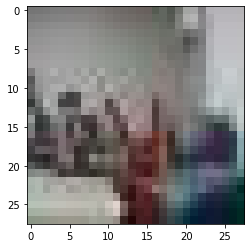

In [22]:
# 이미지 불러와보기
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

# 딥러닝 네트워크 설계하기

In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

# 모델 학습 및 훈련

In [14]:
# 학습_Ver.1 (w.이미지 300개)
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 [==============================] - 1s 21ms/step - loss: 25.3643 - accuracy: 0.3567
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 5.3680 - accuracy: 0.3667
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 1.7295 - accuracy: 0.5933
Epoch 4/10
10/10 [==============================] - 0s 22ms/step - loss: 0.7537 - accuracy: 0.7467
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 0.6880 - accuracy: 0.7533
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.5123 - accuracy: 0.8133
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.2756 - accuracy: 0.8933
Epoch 8/10
10/10 [==============================] - 0s 23ms/step - loss: 0.2027 - accuracy: 0.9333
Epoch 9/10
10/10 [==============================] - 0s 21ms/step - loss: 0.1242 - accuracy: 0.9667
Epoch 10/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0885 - accuracy: 0.9800


In [24]:
# 학습_Ver.2 - 이미지 왕창 추가 (w.이미지 3000개)
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
94/94 [==============================] - 2s 19ms/step - loss: 0.7087 - accuracy: 0.9477
Epoch 2/10
94/94 [==============================] - 2s 19ms/step - loss: 0.1082 - accuracy: 0.9777
Epoch 3/10
94/94 [==============================] - 2s 20ms/step - loss: 0.0218 - accuracy: 0.9937
Epoch 4/10
94/94 [==============================] - 2s 24ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 5/10
94/94 [==============================] - 2s 20ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 6/10
94/94 [==============================] - 2s 19ms/step - loss: 5.1272e-04 - accuracy: 1.0000
Epoch 7/10
94/94 [==============================] - 2s 19ms/step - loss: 4.4878e-04 - accuracy: 1.0000
Epoch 8/10
94/94 [==============================] - 2s 19ms/step - loss: 2.8114e-04 - accuracy: 1.0000
Epoch 9/10
94/94 [==============================] - 2s 19ms/step - loss: 2.2804e-04 - accuracy: 1.0000
Epoch 10/10
94/94 [==============================] - 2s 19ms/step - loss: 1.9522e-04 - accura

# 평가 - 테스트 데이터로 성능 확인

In [ ]:
# 추가 test용 이미지 업로드
# !mkdir -p ~/aiffel/rock_scissor_paper/test

In [15]:
# x_test, y_test 생성
# image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
# resize_images(image_dir_path)

# image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
# resize_images(image_dir_path)

# image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
# resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [25]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)

print(x_test.shape)

학습데이터(x_train)의 이미지 개수는 300 입니다.
(3000, 28, 28, 3)


In [26]:
print('최소값:',np.min(x_test), ' 최대값:',np.max(x_test))

최소값: 0  최대값: 249


In [27]:
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (3000, 28, 28, 3)
y_test shape: (3000,)


In [26]:
# 모델 학습(1) - (w.이미지 300개)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.3153 - accuracy: 0.4833
test_loss: 2.315256357192993 
test_accuracy: 0.4833333194255829


In [27]:
# 모델 학습(2) - 정규화
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.0950 - accuracy: 0.3800
test_loss: 1.0950102806091309 
test_accuracy: 0.3799999952316284


In [28]:
# 모델 학습(3) - 이미지 개수 왕창 추가 (w.이미지 3000개)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

94/94 - 1s - loss: 0.5613 - accuracy: 0.9430
test_loss: 0.5613322257995605 
test_accuracy: 0.9430000185966492


# 어떤 데이터 잘 못 추론했는지 확인

In [22]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [7.5741002e-04 6.4418174e-02 9.3482447e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


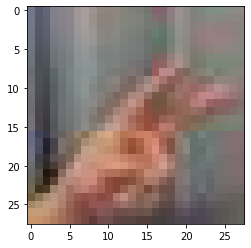

In [23]:
# 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

예측확률분포: [0.04921238 0.65689015 0.29389745]
라벨: 0, 예측결과: 1


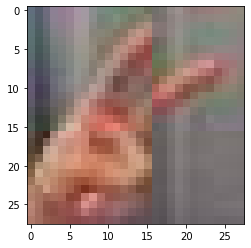

예측확률분포: [0.01425644 0.08029395 0.9054496 ]
라벨: 0, 예측결과: 2


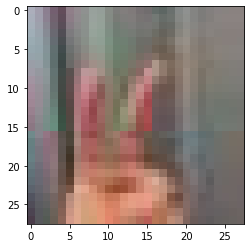

예측확률분포: [9.9992967e-01 3.0928200e-05 3.9405615e-05]
라벨: 1, 예측결과: 0


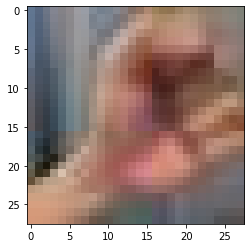

예측확률분포: [0.0010132  0.01092814 0.9880586 ]
라벨: 1, 예측결과: 2


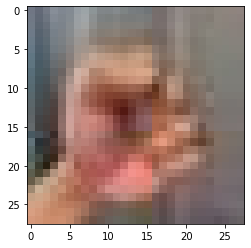

예측확률분포: [3.3402486e-07 4.3780590e-05 9.9995589e-01]
라벨: 0, 예측결과: 2


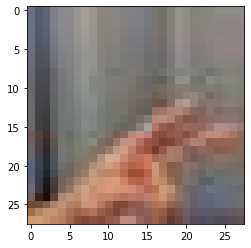

In [24]:
# 모델이 추론한 숫자와 실제 라벨 값이 다른 경우는 언제인지 추가 확인
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

# 파라미터 조정하여 성능 개선 시도

In [ ]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=32
n_channel_2=64
n_dense=32
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")